## Information Retrieval lab5

- Martyna Stasiak id.156071
- Maria Musiał id.156062
----

The purpose of the exercise is to implement a recommendation system for a movie search engine.

When we think about selecting a video that our user will like, let's first consider what data we have available? First of all, we have information in the database about how our user rated the movies he once watched. It's worth noting here that this is absolutely not all of the movies in our database given, and most often it's a heavily limited subset of a huge set of movies. So we can find out which movies our user liked and which ones he didn't. 

Is this all the data available? Well, no! We also have information about the preferences of other users! So we can find in the data a sample of users who have similar movie taste to our user. Note that virtually every such other user has watched some movies that our user has never watched before! The idea behind collaborative filtering is very simple: if another user with similar tastes rated a movie highly, our user will probably rate it highly too! Let's recommend movies that users with similar tastes have rated highly!


Let's formalize some ideas:
 - how to count the similarity between users' tastes? 
 
 Just calculate the correlation between their movie ratings. Users with a strongly positive correlation have similar tastes, and those with a strongly negative correlation have opposite tastes;) 
 
 - Having found similar users, how to count the predicted rating of the video by our user?
 
 We count the weighted average of ratings of users with similar tastes where the weight is the measure of similarity (correlation). The closer a user's tastes are to us, the more weight his rating has for us. (slide 27, http://www.mmds.org/mmds/v2.1/ch09-recsys1.pdf)


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import random
# import ace_tools as tools

pd.set_option("display.max_columns", None) 
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)
from IPython.core.display import display, HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv('./ratings.csv')
df

import matplotlib.pyplot as plt

C:\Users\mmart\AppData\Local\Temp\ipykernel_15408\195331718.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
random.seed(24)

-----

### <b>Task 1
Modify the dataframe to have moveID as index, userID as column and rating as values

In [3]:
dfTask = df.pivot(index='movieId', columns='userId', values='rating')
dfTask.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.5,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,5.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,4.0,NaN,2.5,NaN,NaN,5.0,NaN,4.5,NaN,NaN,0.5,NaN,4.0,NaN,NaN,NaN,2.5,NaN,NaN,NaN,4.0,NaN,NaN,3.0,3.0,4.0,NaN,3.0,NaN,NaN,5.0,NaN,4.5,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN,3.0,4.0,NaN,4.0,NaN,NaN,3.0,4.0,NaN,NaN,3.5,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,3.0,4.0,NaN,NaN,4.5,4.0,4.0,NaN,NaN,NaN,NaN,5.0,3.5,NaN,4.5,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,4.0,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,5.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.0,NaN,3.0,4.0,NaN,3.5,5.0,NaN,NaN,3.5,NaN,NaN,3.5,NaN,NaN,5.0,NaN,NaN,3.5,3.0,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,4.5,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,N

#### Now let's also see some stats about our movie database

In [4]:
numMovies = dfTask.shape[0]
numUsers = dfTask.shape[1]

numNonNan = dfTask.notna().sum().sum()
numNan = dfTask.isna().sum().sum()

#most and least watched movies:
movieWatchCount = dfTask.count(axis=1)
mostWatchedMovie = movieWatchCount.idxmax()
mostWatchedMovieWatchCount = movieWatchCount.max()
leastWatchedMovie = movieWatchCount.idxmin()
leastWatchedMovieWatchCount = movieWatchCount.min()

#most and least active users:
userWatchCount = dfTask.count(axis=0)
mostActiveUser = userWatchCount.idxmax()
mostActiveUserWatchCount = userWatchCount.max()
leastActiveUser = userWatchCount.idxmin()
leastActiveUserWatchCount = userWatchCount.min()


print(f"Dataset summary:")
print(f"Number of movies in the dataset: {numMovies}")
print(f"Number of users in the dataset: {numUsers}")
print(f"Number of non-NaN values in the dataset: {numNonNan}")
print(f"Number of NaN values in the dataset: {numNan}\n")

print(f"Most watched movie: {mostWatchedMovie} ({mostWatchedMovieWatchCount} watches)")
print(f"Least watched movie: {leastWatchedMovie} ({leastWatchedMovieWatchCount} watches)\n")

print(f"Most active user: {mostActiveUser} ({mostActiveUserWatchCount} movies rated)")
print(f"Least active user: {leastActiveUser} ({leastActiveUserWatchCount} movies rated)\n")


Dataset summary:
Number of movies in the dataset: 9724
Number of users in the dataset: 610
Number of non-NaN values in the dataset: 100836
Number of NaN values in the dataset: 5830804

Most watched movie: 356 (329 watches)
Least watched movie: 49 (1 watches)

Most active user: 414 (2698 movies rated)
Least active user: 53 (20 movies rated)



Small remark: <br>
Those stats for the most/least active user and watched movie might be different since there are different movies that might have the same 'watch count' (same with the users) and we print only one of them :)

--------

### <b>Task 2
Let's try to recommend movies for user 610. Calculate the correlation between this user and the remaining ones.

In [5]:
user = 610
user
userRatings = dfTask[user]
userRatings
print(f"User {user} has rated {userRatings.count()} movies")
print(f"Ratings of user {user}:\n {userRatings.dropna()}")


User 610 has rated 1302 movies
Ratings of user 610:
 movieId
1         5.0
6         5.0
16        4.5
32        4.5
47        5.0
         ... 
166534    4.0
168248    5.0
168250    5.0
168252    5.0
170875    3.0
Name: 610, Length: 1302, dtype: float64


In [6]:
def CalculatetCorrelations(user = 610, commonMovies=2, moviesdf=dfTask):
    correlations = {}
    userRatings = moviesdf[user].dropna()
    
    for otherUser in moviesdf.columns:
        if otherUser != user:
            otherUserRatings = moviesdf[otherUser].dropna()
            commonRatings = userRatings.index.intersection(otherUserRatings.index)
            
            if len(commonRatings) >= commonMovies:
                # Extract common ratings
                userCommonRatings = userRatings[commonRatings]
                otherUserCommonRatings = otherUserRatings[commonRatings]
                
                # Check if either array is constant
                if len(set(userCommonRatings)) > 1 and len(set(otherUserCommonRatings)) > 1:
                    correlations[otherUser] = pearsonr(userCommonRatings, otherUserCommonRatings)[0]

    # Filter out NaN correlations
    valid_correlations = {k: v for k, v in correlations.items() if not np.isnan(v)}
                
    sorted_correlations = sorted(valid_correlations.items(), key=lambda x: x[1], reverse=True)
    return sorted_correlations

In [7]:
user610Correlations = CalculatetCorrelations(user=610)
print(f"Top correlated users with the user {user} are:")
for user, corr in user610Correlations[:10]:
    print(f"User {user} with correlation {corr:.2f}")

Top correlated users with the user 610 are:
User 442 with correlation 1.00
User 545 with correlation 1.00
User 576 with correlation 1.00
User 158 with correlation 0.91
User 92 with correlation 0.90
User 595 with correlation 0.89
User 120 with correlation 0.88
User 463 with correlation 0.82
User 138 with correlation 0.82
User 494 with correlation 0.81


---------

### <b>Task 2b
There are a few users with the perfect match. Isn't it suspicious? Check it

In [8]:
user610Ratings = dfTask[610].dropna()
print(f"User 610 has rated {user610Ratings.count()} movies")
user442Ratings = dfTask[442].dropna()
print(f"User 442 has rated {user442Ratings.count()} movies")
commonMoviesRated = user610Ratings.index.intersection(user442Ratings.index)
print(f"User 610 and User 442 have rated {len(commonMoviesRated)} common movies")

User 610 has rated 1302 movies
User 442 has rated 20 movies
User 610 and User 442 have rated 2 common movies


In [9]:
user610Ratings = dfTask[610].dropna()
print(f"User 610 has rated {user610Ratings.count()} movies")
user545Ratings = dfTask[545].dropna()
print(f"User 545 has rated {user545Ratings.count()} movies")
commonMoviesRated = user610Ratings.index.intersection(user545Ratings.index)
print(f"User 610 and User 545 have rated {len(commonMoviesRated)} common movies")

User 610 has rated 1302 movies
User 545 has rated 23 movies
User 610 and User 545 have rated 2 common movies


In [10]:
user610Ratings = dfTask[610].dropna()
print(f"User 610 has rated {user610Ratings.count()} movies")
user576Ratings = dfTask[576].dropna()
print(f"User 576 has rated {user576Ratings.count()} movies")
commonMoviesRated = user610Ratings.index.intersection(user576Ratings.index)
print(f"User 610 and User 576 have rated {len(commonMoviesRated)} common movies")

User 610 has rated 1302 movies
User 576 has rated 20 movies
User 610 and User 576 have rated 2 common movies


and on th other hand:

In [11]:
user610Ratings = dfTask[610].dropna()
print(f"User 610 has rated {user610Ratings.count()} movies")
user158Ratings = dfTask[158].dropna()
print(f"User 158 has rated {user158Ratings.count()} movies")
commonMoviesRated = user610Ratings.index.intersection(user158Ratings.index)
print(f"User 610 and User 158 have rated {len(commonMoviesRated)} common movies")

User 610 has rated 1302 movies
User 158 has rated 26 movies
User 610 and User 158 have rated 4 common movies


In [12]:
user610Ratings = dfTask[610].dropna()
print(f"User 610 has rated {user610Ratings.count()} movies")
user92Ratings = dfTask[92].dropna()
print(f"User 92 has rated {user92Ratings.count()} movies")
commonMoviesRated = user610Ratings.index.intersection(user92Ratings.index)
print(f"User 610 and User 92 have rated {len(commonMoviesRated)} common movies")

User 610 has rated 1302 movies
User 92 has rated 24 movies
User 610 and User 92 have rated 5 common movies


In [13]:
user610Ratings = dfTask[610].dropna()
print(f"User 610 has rated {user610Ratings.count()} movies")
user494Ratings = dfTask[494].dropna()
print(f"User 494 has rated {user494Ratings.count()} movies")
commonMoviesRated = user610Ratings.index.intersection(user494Ratings.index)
print(f"User 610 and User 494 have rated {len(commonMoviesRated)} common movies")

User 610 has rated 1302 movies
User 494 has rated 22 movies
User 610 and User 494 have rated 19 common movies


`The perfect match occurs in those 3 cases because the users have small number of movies in common (only 2), so it is not quite reliable.`

----

### <b>Task 3
Find 5 users with at least 5 common movies with user=610 and the highest correlation with that user

In [14]:
numTopUsers = 5
commonMovies = 5
user610Correlations = CalculatetCorrelations(user = 610, commonMovies = commonMovies)
Best5CorrelatedUsers = user610Correlations[:numTopUsers]

print(f"Top {numTopUsers} correlated users with the user {user}, who have wathced at least {commonMovies} same movies are:")
for otherUser, correlation in Best5CorrelatedUsers:
    print(f"User {otherUser} with correlation {correlation:.2f}")


Top 5 correlated users with the user 494, who have wathced at least 5 same movies are:
User 92 with correlation 0.90
User 120 with correlation 0.88
User 463 with correlation 0.82
User 138 with correlation 0.82
User 494 with correlation 0.81


-------

### <b> Task 4
Predict scores for each movie based on the most correlated users. Use weighted average with correlation coefficient as weights.
$$\hat{y_j} = \frac{\sum_{i \in U} w_iy_{ij}}{\sum_{i \in U} w_i}$$

$U$ is a set of those users that also watched $j$th moveie, $w$ denotes the correlation between our user and $i$th user, $y_{ij}$ is a score given by $i$th user to $j$th movie
Use only movies watched by at least two users from the considered set

In [15]:
def predictScores(user, moviesdf = dfTask, commonMovies = 5, topUsers = 5, negativeUsers=0, sortBy='Predicted Score'):
    userXCorrelations = CalculatetCorrelations(user, commonMovies, moviesdf)
    topNUsers = userXCorrelations[:topUsers]
    worstNUsers = userXCorrelations[-negativeUsers:]
    predictedScores = []
    
    for movie in moviesdf.index:
        if np.isnan(moviesdf.loc[movie, user]):
            predictedScore = 0
            sumCorr = 0
            otherUserDetails = []
            contibutingUsers = 0
            
            for otherUser, correlation in topNUsers:
                otherUserRating = moviesdf.loc[movie, otherUser]
                if not np.isnan(otherUserRating):
                    predictedScore += otherUserRating * correlation
                    sumCorr += correlation
                    contibutingUsers += 1
                    otherUserDetails.append(f"User: {otherUser}, Rating: {otherUserRating}, Correlation: {correlation:.2f}")
                    
            if negativeUsers != 0:
                for otherUser, correlation in worstNUsers:
                    otherUserRating = moviesdf.loc[movie, otherUser]
                    if not np.isnan(otherUserRating):
                        predictedScore += abs((abs(6 - otherUserRating)) * correlation)
                        sumCorr += abs(correlation)
                        contibutingUsers += 1
                        otherUserDetails.append(f"User: {otherUser}, Rating: {otherUserRating}, Correlation: {correlation:.2f}")
                    
            if sumCorr != 0:
                predictedScore /= sumCorr
                otherUserDetailsStr = '<br>'.join(otherUserDetails)
                predictedScores.append({'Movie': movie, 'Predicted Score': predictedScore, 'Count of users contributing to prediction': contibutingUsers, 'Users on based on which prediction was made details': otherUserDetailsStr})
                
    if sortBy == 'User':
        predictedScoresdf = pd.DataFrame(predictedScores).sort_values(by=['Count of users contributing to prediction', 'Predicted Score'], ascending=[False, False])
    else:
        predictedScoresdf = pd.DataFrame(predictedScores).sort_values(by=['Predicted Score', 'Count of users contributing to prediction'], ascending=[False, False])

                
                
    # predictedScoresdf = pd.DataFrame(predictedScores).sort_values(by='Predicted Score', ascending=False)         
    return predictedScoresdf



In [16]:
predictedRatings300 = predictScores(300)
display(HTML(predictedRatings300.head(10).to_html(escape=False)))

,Movie,Predicted Score,Count of users contributing to prediction,Users on based on which prediction was made details
120,1221,5.0,3,"User: 168, Rating: 5.0, Correlation: 0.91User: 412, Rating: 5.0, Correlation: 0.80User: 409, Rating: 5.0, Correlation: 0.78"
67,908,5.0,2,"User: 168, Rating: 5.0, Correlation: 0.91User: 412, Rating: 5.0, Correlation: 0.80"
76,924,5.0,2,"User: 29, Rating: 5.0, Correlation: 0.86User: 412, Rating: 5.0, Correlation: 0.80"
107,1197,5.0,2,"User: 412, Rating: 5.0, Correlation: 0.80User: 409, Rating: 5.0, Correlation: 0.78"
132,1247,5.0,2,"User: 168, Rating: 5.0, Correlation: 0.91User: 409, Rating: 5.0, Correlation: 0.78"
135,1252,5.0,2,"User: 168, Rating: 5.0, Correlation: 0.91User: 412, Rating: 5.0, Correlation: 0.80"
236,2396,5.0,2,"User: 587, Rating: 5.0, Correlation: 1.00User: 412, Rating: 5.0, Correlation: 0.80"
307,3037,5.0,2,"User: 587, Rating: 5.0, Correlation: 1.00User: 409, Rating: 5.0, Correlation: 0.78"
2,17,5.0,1,"User: 412, Rating: 5.0, Correlation: 0.80"
4,32,5.0,1,"User: 587, Rating: 5.0, Correlation: 1.00"


In [17]:
predictedRatings610 = predictScores(610)
display(HTML(predictedRatings610.head(10).to_html(escape=False)))

,Movie,Predicted Score,Count of users contributing to prediction,Users on based on which prediction was made details
3,107,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
5,222,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
21,837,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
23,898,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
25,1019,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
49,2150,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
55,2572,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
10,616,4.5,1,"User: 138, Rating: 4.5, Correlation: 0.82"
34,1552,4.5,1,"User: 463, Rating: 4.5, Correlation: 0.82"
45,2087,4.5,1,"User: 92, Rating: 4.5, Correlation: 0.90"


In [18]:
predictedRatings610 = predictScores(610, sortBy='User')
display(HTML(predictedRatings610.head(10).to_html(escape=False)))

,Movie,Predicted Score,Count of users contributing to prediction,Users on based on which prediction was made details
32,1367,3.493226,2,"User: 92, Rating: 3.0, Correlation: 0.90User: 120, Rating: 4.0, Correlation: 0.88"
3,107,5.000000,1,"User: 92, Rating: 5.0, Correlation: 0.90"
5,222,5.000000,1,"User: 138, Rating: 5.0, Correlation: 0.82"
21,837,5.000000,1,"User: 92, Rating: 5.0, Correlation: 0.90"
23,898,5.000000,1,"User: 138, Rating: 5.0, Correlation: 0.82"
25,1019,5.000000,1,"User: 138, Rating: 5.0, Correlation: 0.82"
49,2150,5.000000,1,"User: 138, Rating: 5.0, Correlation: 0.82"
55,2572,5.000000,1,"User: 92, Rating: 5.0, Correlation: 0.90"
10,616,4.500000,1,"User: 138, Rating: 4.5, Correlation: 0.82"
34,1552,4.500000,1,"User: 463, Rating: 4.5, Correlation: 0.82"


In [19]:
predictedRatings610withNegative = predictScores(610, negativeUsers=5)
display(HTML(predictedRatings610withNegative.head(10).to_html(escape=False)))

,Movie,Predicted Score,Count of users contributing to prediction,Users on based on which prediction was made details
8,107,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
15,196,5.0,1,"User: 536, Rating: 1.0, Correlation: -0.64"
22,253,5.0,1,"User: 536, Rating: 1.0, Correlation: -0.64"
47,431,5.0,1,"User: 536, Rating: 1.0, Correlation: -0.64"
80,837,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
83,898,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
86,1019,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
120,2150,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
67,616,4.5,1,"User: 138, Rating: 4.5, Correlation: 0.82"
101,1552,4.5,1,"User: 463, Rating: 4.5, Correlation: 0.82"


In [20]:
predictedRatings610withMoreNegative = predictScores(610, negativeUsers=15)
display(HTML(predictedRatings610withNegative.head(10).to_html(escape=False)))

,Movie,Predicted Score,Count of users contributing to prediction,Users on based on which prediction was made details
8,107,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
15,196,5.0,1,"User: 536, Rating: 1.0, Correlation: -0.64"
22,253,5.0,1,"User: 536, Rating: 1.0, Correlation: -0.64"
47,431,5.0,1,"User: 536, Rating: 1.0, Correlation: -0.64"
80,837,5.0,1,"User: 92, Rating: 5.0, Correlation: 0.90"
83,898,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
86,1019,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
120,2150,5.0,1,"User: 138, Rating: 5.0, Correlation: 0.82"
67,616,4.5,1,"User: 138, Rating: 4.5, Correlation: 0.82"
101,1552,4.5,1,"User: 463, Rating: 4.5, Correlation: 0.82"


-----

### <b> Task 5
How to check the quality of our recommendations? 

We have to remove a few scores from the dataset and then compare predictions with the real ones.

First to not permamently change the dataframe that we work on I hve created the copy of it, so that when we remove some ratings our dfTask will not be affected and we will be able to compare the changes.

In [21]:
dfTaskComparing = dfTask.copy()
dfTaskComparing.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,4.5,3.5,4.0,NaN,3.5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,5.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,4.0,NaN,2.5,NaN,NaN,5.0,NaN,4.5,NaN,NaN,0.5,NaN,4.0,NaN,NaN,NaN,2.5,NaN,NaN,NaN,4.0,NaN,NaN,3.0,3.0,4.0,NaN,3.0,NaN,NaN,5.0,NaN,4.5,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,NaN,3.0,4.0,NaN,4.0,NaN,NaN,3.0,4.0,NaN,NaN,3.5,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,3.0,4.0,NaN,NaN,4.5,4.0,4.0,NaN,NaN,NaN,NaN,5.0,3.5,NaN,4.5,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,4.0,NaN,NaN,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,5.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.0,NaN,3.0,4.0,NaN,3.5,5.0,NaN,NaN,3.5,NaN,NaN,3.5,NaN,NaN,5.0,NaN,NaN,3.5,3.0,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN,4.5,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,N

Now let's create the function that removes some ratings for a provided user.

In [22]:
def removeRatings(user, numScoresToRemove, moviesdf = dfTaskComparing):
    userRatings = moviesdf[user].dropna()
    if len(userRatings) > numScoresToRemove:
        
        moviesToRemove = random.sample(list(userRatings.index), numScoresToRemove)
        moviesdf.loc[moviesToRemove, user] = np.nan
        return moviesdf, moviesToRemove
    else:
        return "You want to remove more ratings for a user thathey actually have!"

In [23]:
def compareRemovedRatings(user, numScoresToRemove, moviesdf = dfTaskComparing, topUsers=5):
    moviesdfChanged, removedMovies = removeRatings(user, numScoresToRemove, moviesdf)
    print(f"Removed ratings for user {user} for movies: {removedMovies}\n")
    
    predictedRatings = predictScores(user, moviesdfChanged, topUsers=topUsers)
    trueRatingsList=[]
    predictedScoresList=[]
    
    for movie in removedMovies:
        trueRating=dfTask.loc[movie, user]
        print(f"True rating for movie {movie}: {trueRating}")
        
        prediction = predictedRatings[predictedRatings['Movie'] == movie]
        if not prediction.empty:
            predictedScore = prediction['Predicted Score'].values[0]
            trueRatingsList.append(trueRating)
            predictedScoresList.append(predictedScore)
            print(f"Predicted rating for movie {movie}: {predictedScore}\n")
        else:
            print(f"Predicted rating for movie {movie}: No prediction possible\n")
            
    print(f"With provide parameters the {len(predictedScoresList)} predictions were made out of {numScoresToRemove} possible ones.")
    if trueRatingsList and predictedScoresList:
        mae = mean_absolute_error(trueRatingsList, predictedScoresList)
        rmse = np.sqrt(mean_squared_error(trueRatingsList, predictedScoresList))
        print(f"Evaluation metrics:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Squared Error (EMSE): {rmse:.2f}")
    else:
        print(f"Not enough data to calculate evaluation metrics.")
    return predictedRatings, removedMovies

In [24]:
predictedRatings, removedMovies = compareRemovedRatings(user = 26, numScoresToRemove = 5, topUsers = 20)

Removed ratings for user 26 for movies: [344, 457, 165, 185, 592]

True rating for movie 344: 3.0
Predicted rating for movie 344: 3.5665790550765646

True rating for movie 457: 4.0
Predicted rating for movie 457: 4.062842949435575

True rating for movie 165: 4.0
Predicted rating for movie 165: 2.9953508390676795

True rating for movie 185: 3.0
Predicted rating for movie 185: 2.487329110524666

True rating for movie 592: 4.0
Predicted rating for movie 592: 3.9069850123057024

With provide parameters the 5 predictions were made out of 5 possible ones.
Evaluation metrics:
Mean Absolute Error (MAE): 0.45
Root Mean Squared Error (EMSE): 0.57


In [25]:
predictedRatings, removedMovies = compareRemovedRatings(user = 92, numScoresToRemove = 15, topUsers = 20)

Removed ratings for user 92 for movies: [1619, 1367, 54190, 837, 1021, 2087, 107, 2501, 2664, 2454, 2139, 2114, 327, 3168, 2085]

True rating for movie 1619: 4.0
Predicted rating for movie 1619: 3.1301316568020527

True rating for movie 1367: 3.0
Predicted rating for movie 1367: 2.8775111645843037

True rating for movie 54190: 4.0
Predicted rating for movie 54190: 4.018711267998723

True rating for movie 837: 5.0
Predicted rating for movie 837: 1.6196975547481338

True rating for movie 1021: 3.0
Predicted rating for movie 1021: 1.8923315296956256

True rating for movie 2087: 4.5
Predicted rating for movie 2087: 3.952704881772975

True rating for movie 107: 5.0
Predicted rating for movie 107: -0.5911873178508159

True rating for movie 2501: 4.0
Predicted rating for movie 2501: 3.1543323287149856

True rating for movie 2664: 3.5
Predicted rating for movie 2664: No prediction possible

True rating for movie 2454: 4.0
Predicted rating for movie 2454: No prediction possible

True rating for

In [26]:
predictedRatings, removedMovies = compareRemovedRatings(user = 30, numScoresToRemove = 2, topUsers = 5)

Removed ratings for user 30 for movies: [1291, 115617]

True rating for movie 1291: 5.0
Predicted rating for movie 1291: 4.510149244765452

True rating for movie 115617: 5.0
Predicted rating for movie 115617: No prediction possible

With provide parameters the 1 predictions were made out of 2 possible ones.
Evaluation metrics:
Mean Absolute Error (MAE): 0.49
Root Mean Squared Error (EMSE): 0.49


In [27]:
predictedRatings, removedMovies = compareRemovedRatings(user = 106, numScoresToRemove = 3, topUsers = 12)

Removed ratings for user 106 for movies: [88125, 59784, 106489]

True rating for movie 88125: 5.0
Predicted rating for movie 88125: 4.0

True rating for movie 59784: 5.0
Predicted rating for movie 59784: 3.5

True rating for movie 106489: 5.0
Predicted rating for movie 106489: 4.0460590678182635

With provide parameters the 3 predictions were made out of 3 possible ones.
Evaluation metrics:
Mean Absolute Error (MAE): 1.15
Root Mean Squared Error (EMSE): 1.18


In [28]:
predictedRatings, removedMovies = compareRemovedRatings(user = 600, numScoresToRemove = 20, topUsers = 20)

Removed ratings for user 600 for movies: [491, 30793, 1707, 6377, 1037, 27020, 2266, 2115, 374, 4621, 8169, 2455, 8665, 203, 1333, 2140, 2318, 59725, 362, 2134]

True rating for movie 491: 3.0
Predicted rating for movie 491: No prediction possible

True rating for movie 30793: 3.0
Predicted rating for movie 30793: No prediction possible

True rating for movie 1707: 3.0
Predicted rating for movie 1707: No prediction possible

True rating for movie 6377: 4.0
Predicted rating for movie 6377: 4.5386423455635825

True rating for movie 1037: 3.0
Predicted rating for movie 1037: No prediction possible

True rating for movie 27020: 3.0
Predicted rating for movie 27020: No prediction possible

True rating for movie 2266: 3.5
Predicted rating for movie 2266: No prediction possible

True rating for movie 2115: 3.5
Predicted rating for movie 2115: No prediction possible

True rating for movie 374: 3.0
Predicted rating for movie 374: 1.0

True rating for movie 4621: 2.0
Predicted rating for movie 4

----

# `Improving the system`

Now let's improve the general function to easily compare the results, for different numbers of least number of movies to be watched by the users to get the ratings, and the numbers of top corelated users that we predict rating based on.

In [29]:
def compareRemovedRatingsGiga(user, numScoresToRemove, moviesdf = dfTaskComparing, topUsers=5, commonMovies = 5, negativeUsers=0):
    moviesdfChanged, removedMovies = removeRatings(user, numScoresToRemove, moviesdf)
    
    predictedRatings = predictScores(user, moviesdfChanged, topUsers=topUsers, commonMovies=commonMovies, negativeUsers=negativeUsers)
    trueRatingsList=[]
    predictedScoresList=[]
    
    for movie in removedMovies:
        trueRating=dfTask.loc[movie, user]
        
        prediction = predictedRatings[predictedRatings['Movie'] == movie]
        if not prediction.empty:
            predictedScore = prediction['Predicted Score'].values[0]
            trueRatingsList.append(trueRating)
            predictedScoresList.append(predictedScore)
        else:
            continue            
    if trueRatingsList and predictedScoresList:
        mae = mean_absolute_error(trueRatingsList, predictedScoresList)
        rmse = np.sqrt(mean_squared_error(trueRatingsList, predictedScoresList))

    else:
        mae = None
        rmse = None
        print(f"Not enough data to calculate evaluation metrics.")
    return predictedRatings, removedMovies, mae, rmse, len(predictedScoresList)

## 1) Incorporating more users:
In here we tested different number of users based on which the prediction of rating is being made. <br>
First we tested the numbers from 5 to 50 with step of 5 users with highest correlation and plotted how the mean absolute error depends on the number of the users that prediction of grade bases of.

This and other similair cells of code, testing different oarameters and performance of the system run for 15+ minutes each so I advise to not run it again :)

In [30]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
numScoresToRemove = 10
commonMovies = 5
top_users_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]  #different top users that we use for the prediction


results = {}

#we iterate through every topuser number and get their mae to compare them
for topUsers in top_users_range:
    maeLIST = []
    for user in users:
        sparklingNewdf = dfTask.copy()
        predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
            user=user, moviesdf=sparklingNewdf, numScoresToRemove=numScoresToRemove, 
            topUsers=topUsers, commonMovies=commonMovies
        )
        if mae is not None:
            maeLIST.append(mae)
    
    # sum and average mae for the current topUsers
    maeSUM = sum(maeLIST)
    maeAVG = maeSUM / len(maeLIST) if maeLIST else None  # Handle empty maeLIST
    
    # storing the results for the current topUsers
    results[topUsers] = {
        "maeSUM": maeSUM,
        "maeAVG": maeAVG,
        "maeLIST": maeLIST,
    }

    #check if work might delete if feel pretty
    print(f"topUsers={topUsers} -> Sum of MAE: {maeSUM}, Average MAE: {maeAVG}")



topUsers=5 -> Sum of MAE: 5.948642838573777, Average MAE: 0.7435803548217221
Not enough data to calculate evaluation metrics.
topUsers=10 -> Sum of MAE: 5.51372555686254, Average MAE: 0.7876750795517914
topUsers=15 -> Sum of MAE: 9.380501158117845, Average MAE: 1.1725626447647306
topUsers=20 -> Sum of MAE: 7.68745771294076, Average MAE: 0.960932214117595
topUsers=25 -> Sum of MAE: 6.4813629487470354, Average MAE: 0.8101703685933794
topUsers=30 -> Sum of MAE: 6.3911373773667455, Average MAE: 0.7988921721708432
topUsers=35 -> Sum of MAE: 7.509657958509087, Average MAE: 0.9387072448136359
topUsers=40 -> Sum of MAE: 7.069084418240214, Average MAE: 0.8836355522800268
topUsers=45 -> Sum of MAE: 6.639788833228325, Average MAE: 0.8299736041535406
topUsers=50 -> Sum of MAE: 6.820370463194552, Average MAE: 0.852546307899319


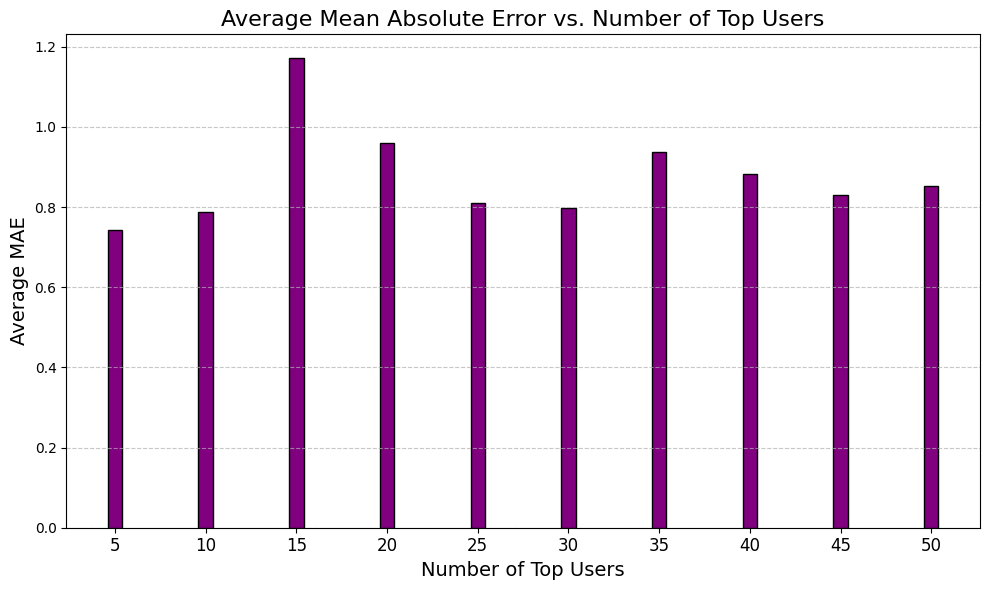

In [31]:
top_users_values = list(results.keys())
average_maes = [results[tu]["maeAVG"] for tu in top_users_values]


plt.figure(figsize=(10, 6))
plt.bar(top_users_values, average_maes, color='purple', edgecolor='black')
plt.xlabel('Number of Top Users', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.title('Average Mean Absolute Error vs. Number of Top Users', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(top_users_values, fontsize=12)
plt.tight_layout()
plt.show()

`From the plot we see that the lowest avegare mean absolute error is when we have the prediction of rating based on the 5 users with the highest correlation, it is about 0.74.` <br> `But since the number of users that we base our prediction is small it is also smart to look at the higher numbers of users that also have similiar but a little bit highet=r average MAE- and that would be 30.`<br>
`But generally the number of top users being 5 gives us quite good results for now.`

------------
## 1b) Including the negtive correlations


In [32]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
numScoresToRemove = 10
topUsers = 5  
commonMovies = 5
negative_users_range = range(0, 11)  #megative users from 1 to 10


results = {}

#loop over the range of negativeUsers
for negativeUsers in negative_users_range:
    maeLIST = []
    for user in users:
        sparklingNewdf = dfTask.copy()
        predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
            user=user, moviesdf=sparklingNewdf, numScoresToRemove=numScoresToRemove, 
            topUsers=topUsers, commonMovies=commonMovies, negativeUsers=negativeUsers
        )
        if mae is not None:
            maeLIST.append(mae)
    
    #sum and average MAE for the current negativeUsers
    maeSUM = sum(maeLIST)
    maeAVG = maeSUM / len(maeLIST) if maeLIST else None  # Handle empty maeLIST
    
    # storing the results for the current topUsers
    results[negativeUsers] = {
        "maeSUM": maeSUM,
        "maeAVG": maeAVG,
        "maeLIST": maeLIST,
    }

    
    print(f"negativeUsers={negativeUsers} -> Sum of MAE: {maeSUM}, Average MAE: {maeAVG}")



Not enough data to calculate evaluation metrics.
Not enough data to calculate evaluation metrics.
negativeUsers=0 -> Sum of MAE: 4.245728746991315, Average MAE: 0.7076214578318858
negativeUsers=1 -> Sum of MAE: 7.203073038489881, Average MAE: 0.9003841298112352
Not enough data to calculate evaluation metrics.
negativeUsers=2 -> Sum of MAE: 12.101412605612381, Average MAE: 1.7287732293731974
negativeUsers=3 -> Sum of MAE: 8.972703761534053, Average MAE: 1.1215879701917566
negativeUsers=4 -> Sum of MAE: 9.981964519565974, Average MAE: 1.2477455649457467
Not enough data to calculate evaluation metrics.
negativeUsers=5 -> Sum of MAE: 8.558512082635897, Average MAE: 1.2226445832336996
Not enough data to calculate evaluation metrics.
negativeUsers=6 -> Sum of MAE: 7.982779629357708, Average MAE: 1.140397089908244
Not enough data to calculate evaluation metrics.
negativeUsers=7 -> Sum of MAE: 10.31519067766725, Average MAE: 1.4735986682381785
Not enough data to calculate evaluation metrics.
n

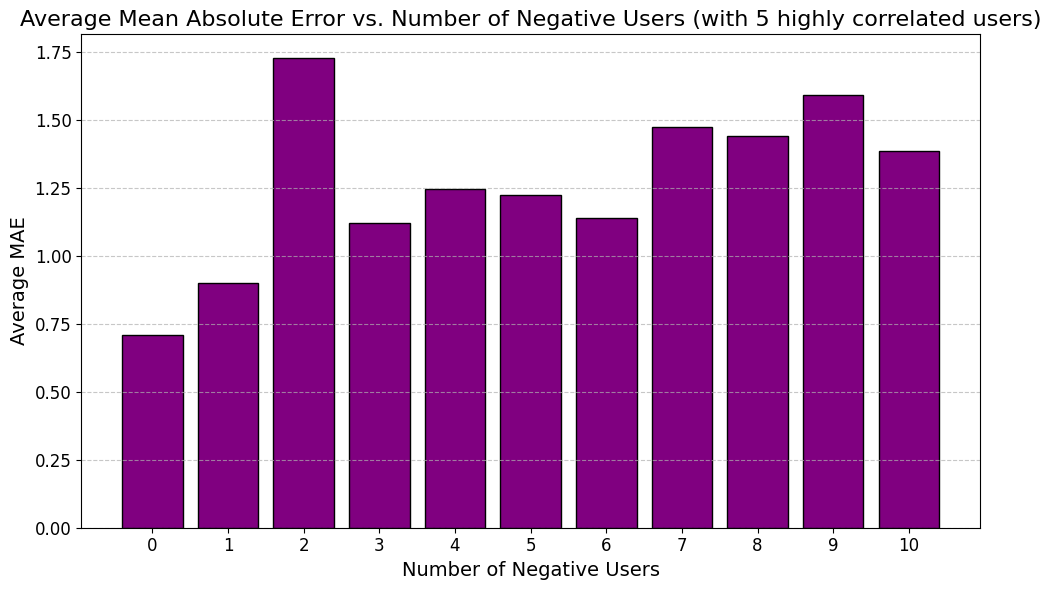

In [33]:
negative_users_values = list(results.keys())
average_maes = [results[nu]["maeAVG"] for nu in negative_users_values]

plt.figure(figsize=(10, 6))
plt.bar(negative_users_values, average_maes, color='purple', edgecolor='black')
plt.xlabel('Number of Negative Users', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.title('Average Mean Absolute Error vs. Number of Negative Users (with 5 highly correlated users)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(negative_users_values, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

`Now when having a 'base' of top 5 users and then adding to the prediction inverted values of negatively correlated users, we see that the system performance drops, because average MAE is increasing when even one negatively correlated user is being added.`<br>
`So when using the topUsers = 5 it would be best to not include the negatively correlated users since when we do that the performance drops.`

In [49]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
numScoresToRemove = 10
topUsers = 30
commonMovies = 5
negative_users_range = range(0, 11)  #megative users from 1 to 10


results = {}

#loop over the range of negativeUsers
for negativeUsers in negative_users_range:
    maeLIST = []
    for user in users:
        sparklingNewdf = dfTask.copy()
        predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
            user=user, moviesdf=sparklingNewdf, numScoresToRemove=numScoresToRemove, 
            topUsers=topUsers, commonMovies=commonMovies, negativeUsers=negativeUsers
        )
        if mae is not None:
            maeLIST.append(mae)
    
    #sum and average MAE for the current negativeUsers
    maeSUM = sum(maeLIST)
    maeAVG = maeSUM / len(maeLIST) if maeLIST else None  # Handle empty maeLIST
    
    # storing the results for the current topUsers
    results[negativeUsers] = {
        "maeSUM": maeSUM,
        "maeAVG": maeAVG,
        "maeLIST": maeLIST,
    }

    
    print(f"negativeUsers={negativeUsers} -> Sum of MAE: {maeSUM}, Average MAE: {maeAVG}")



negativeUsers=0 -> Sum of MAE: 6.662045414251328, Average MAE: 0.832755676781416
negativeUsers=1 -> Sum of MAE: 6.266717911156706, Average MAE: 0.7833397388945883
negativeUsers=2 -> Sum of MAE: 7.82860322666005, Average MAE: 0.9785754033325063
negativeUsers=3 -> Sum of MAE: 7.553759533429668, Average MAE: 0.9442199416787085
negativeUsers=4 -> Sum of MAE: 8.886462994574652, Average MAE: 1.1108078743218315
negativeUsers=5 -> Sum of MAE: 7.41037183402016, Average MAE: 0.92629647925252
negativeUsers=6 -> Sum of MAE: 6.3091584707304875, Average MAE: 0.7886448088413109
negativeUsers=7 -> Sum of MAE: 8.177910636542512, Average MAE: 1.022238829567814
negativeUsers=8 -> Sum of MAE: 7.880347523792849, Average MAE: 0.9850434404741061
negativeUsers=9 -> Sum of MAE: 8.083978662371083, Average MAE: 1.0104973327963853
negativeUsers=10 -> Sum of MAE: 7.090335543059192, Average MAE: 0.886291942882399


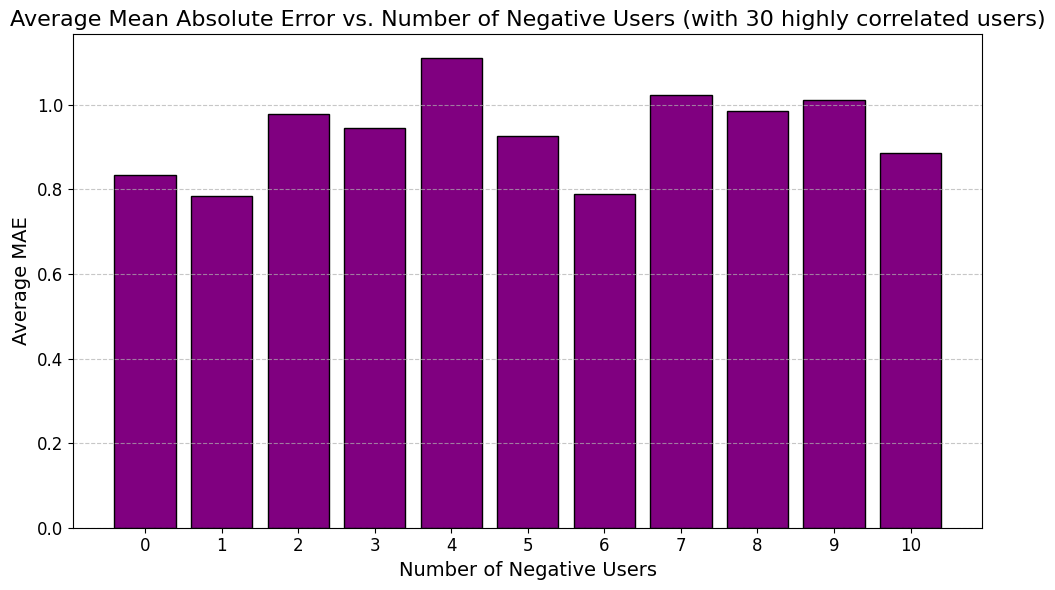

In [50]:
negative_users_values = list(results.keys())
average_maes = [results[nu]["maeAVG"] for nu in negative_users_values]

plt.figure(figsize=(10, 6))
plt.bar(negative_users_values, average_maes, color='purple', edgecolor='black')
plt.xlabel('Number of Negative Users', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.title('Average Mean Absolute Error vs. Number of Negative Users (with 30 highly correlated users)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(negative_users_values, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [54]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
numScoresToRemove = 10
topUsers = 30
commonMovies = 5
negative_users_range = range(0, 11)  #megative users from 1 to 10


results = {}

#loop over the range of negativeUsers
for negativeUsers in negative_users_range:
    maeLIST = []
    for user in users:
        sparklingNewdf = dfTask.copy()
        predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
            user=user, moviesdf=sparklingNewdf, numScoresToRemove=numScoresToRemove, 
            topUsers=topUsers, commonMovies=commonMovies, negativeUsers=negativeUsers
        )
        if mae is not None:
            maeLIST.append(mae)
    
    #sum and average MAE for the current negativeUsers
    maeSUM = sum(maeLIST)
    maeAVG = maeSUM / len(maeLIST) if maeLIST else None  # Handle empty maeLIST
    
    # storing the results for the current topUsers
    results[negativeUsers] = {
        "maeSUM": maeSUM,
        "maeAVG": maeAVG,
        "maeLIST": maeLIST,
    }

    
    print(f"negativeUsers={negativeUsers} -> Sum of MAE: {maeSUM}, Average MAE: {maeAVG}")

negativeUsers=0 -> Sum of MAE: 7.20908012205792, Average MAE: 0.90113501525724
negativeUsers=1 -> Sum of MAE: 5.5926722265272, Average MAE: 0.6990840283159
negativeUsers=2 -> Sum of MAE: 7.0432995984505915, Average MAE: 0.8804124498063239
negativeUsers=3 -> Sum of MAE: 6.949783786865242, Average MAE: 0.8687229733581553
negativeUsers=4 -> Sum of MAE: 6.34889524587646, Average MAE: 0.7936119057345575
negativeUsers=5 -> Sum of MAE: 6.881620435327125, Average MAE: 0.8602025544158907
negativeUsers=6 -> Sum of MAE: 7.999913417620688, Average MAE: 0.999989177202586
negativeUsers=7 -> Sum of MAE: 8.16920676295728, Average MAE: 1.02115084536966
negativeUsers=8 -> Sum of MAE: 7.3204948985356895, Average MAE: 0.9150618623169612
negativeUsers=9 -> Sum of MAE: 9.833366015818905, Average MAE: 1.2291707519773631
negativeUsers=10 -> Sum of MAE: 7.984646697153988, Average MAE: 0.9980808371442484


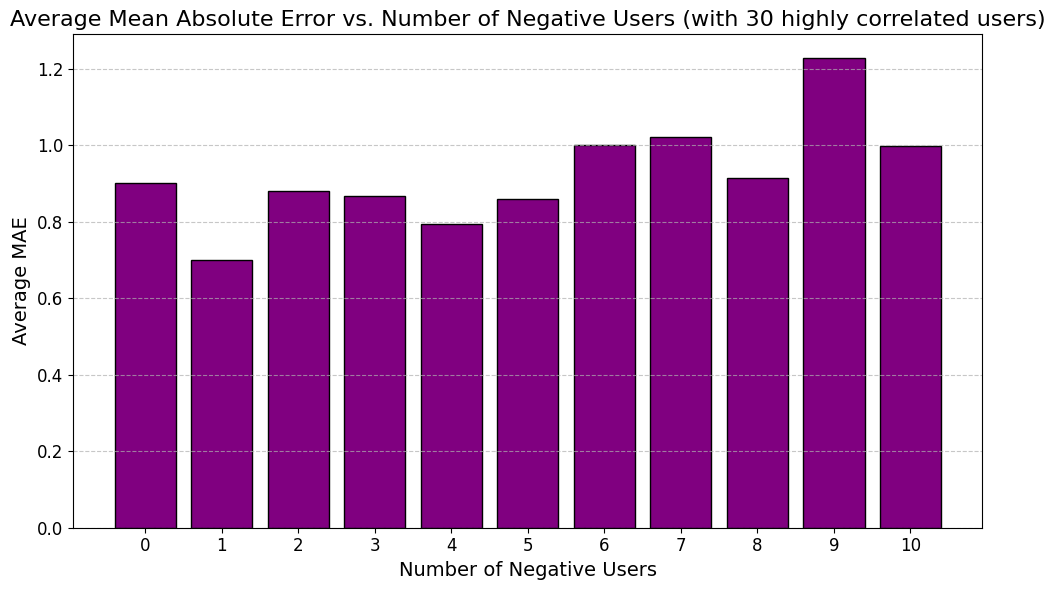

In [55]:
negative_users_values = list(results.keys())
average_maes = [results[nu]["maeAVG"] for nu in negative_users_values]

plt.figure(figsize=(10, 6))
plt.bar(negative_users_values, average_maes, color='purple', edgecolor='black')
plt.xlabel('Number of Negative Users', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.title('Average Mean Absolute Error vs. Number of Negative Users (with 30 highly correlated users)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(negative_users_values, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

`Now we see that when we have the 'base' od 30 users the presence of negatively correlated users increases the model performance, sincethe average MAE with 0 negatively correlated users is worse than presence of less than 5 negatively correlated users (with the best MAE of 0.69 being when there is only one- worst negatively correlated user).` <br> `From this we might gather that when we increase the number of topUsers that we base the prediction rating it would be benefitial to incorporate some negatively correlated users in some ratio.`<br>
`But since we have decided to stick with the number of users (positively correlated) to be 5 we will not be incorporating the negatively correlated users; but all in all when we would set topUsers to 30 would also add 1 negatively correlated user to base the prediction on.`

---

## 2) Which difference is more important predicting 5 when a real score is 4 or predicting 3 instead of 2?

In [36]:
realScores = [4, 2]
predictedScores = [5, 3]


mae1 = mean_absolute_error([realScores[0]], [predictedScores[0]])
print(f"MAE for predicting {predictedScores[0]} instead of {realScores[0]}: {mae1:.2f}")
mae2 = mean_absolute_error([realScores[1]], [predictedScores[1]])
print(f"MAE for predicting {predictedScores[1]} instead of {realScores[1]}: {mae2:.2f}")

rmse1 = mean_squared_error([realScores[0]], [predictedScores[0]])
print(f"RMSE for predicting {predictedScores[0]} instead of {realScores[0]}: {rmse1:.2f}")
rmse2 = mean_squared_error([realScores[1]], [predictedScores[1]])
print(f"RMSE for predicting {predictedScores[1]} instead of {realScores[1]}: {rmse2:.2f}")


MAE for predicting 5 instead of 4: 1.00
MAE for predicting 3 instead of 2: 1.00
RMSE for predicting 5 instead of 4: 1.00
RMSE for predicting 3 instead of 2: 1.00


`Overall the result using the mean absolute erroer and the root mean squared error is the same in those two cases, so mathematiclly it is the same.` <br>
`However  when building the system when we want to recommend the movies to user it would be better to have the first error in predictions, i.e. predicting that user will rate the movie to 5 instead of 4. It is like that because the user will still like the movie, just not as much and they shall be content with it, so generally recommending such a movie to that user would make sense.`<br> `On the other hand if we would predict that user will rate the movie as 3 and in reality they would rate it as 2, it would mean that we predict that the user would be partially content with the movie and the system might recommend it to the user wheras the user would not like it that much and would not be satisfied with this film and by that not liking and/or trusting the recommendations.` <br> 
`So by that it would be better to predict a rating of 5 instad of 4 rather than 3 instead of 2.` 

-------------

## 3) Did we use the best value for the minimal number of common movies?

In [51]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
numScoresToRemove = 10
topUsers = 5
results = {}

#looping over the range of commonMovies (3 to 15)
for commonMovies in range(3, 16):
    maeLIST = []
    for user in users:
        sparklingNewdf = dfTask.copy()
        predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
            user=user, moviesdf=sparklingNewdf, numScoresToRemove=numScoresToRemove, 
            topUsers=topUsers, commonMovies=commonMovies, negativeUsers=0
        )
        if mae is not None:
            maeLIST.append(mae)
    
    #sum and average MAE for the current commonMovies
    maeSUM = sum(maeLIST)
    maeAVG = maeSUM / len(maeLIST) if maeLIST else None  
    
    results[commonMovies] = {
        "maeSUM": maeSUM,
        "maeAVG": maeAVG,
        "maeLIST": maeLIST,
    }
    print(f"commonMovies={commonMovies} -> Sum of MAE: {maeSUM}, Average MAE: {maeAVG}")

Not enough data to calculate evaluation metrics.
Not enough data to calculate evaluation metrics.
commonMovies=3 -> Sum of MAE: 4.33856264704198, Average MAE: 0.7230937745069966
commonMovies=4 -> Sum of MAE: 5.342605599956376, Average MAE: 0.667825699994547
Not enough data to calculate evaluation metrics.
commonMovies=5 -> Sum of MAE: 6.895512883217257, Average MAE: 0.9850732690310366
Not enough data to calculate evaluation metrics.
commonMovies=6 -> Sum of MAE: 3.37275556420086, Average MAE: 0.4818222234572657
Not enough data to calculate evaluation metrics.
commonMovies=7 -> Sum of MAE: 8.553772114524612, Average MAE: 1.2219674449320874
commonMovies=8 -> Sum of MAE: 5.853735796224067, Average MAE: 0.7317169745280083
commonMovies=9 -> Sum of MAE: 9.655508625131455, Average MAE: 1.206938578141432
Not enough data to calculate evaluation metrics.
commonMovies=10 -> Sum of MAE: 8.605008737611179, Average MAE: 1.2292869625158827
Not enough data to calculate evaluation metrics.
Not enough d

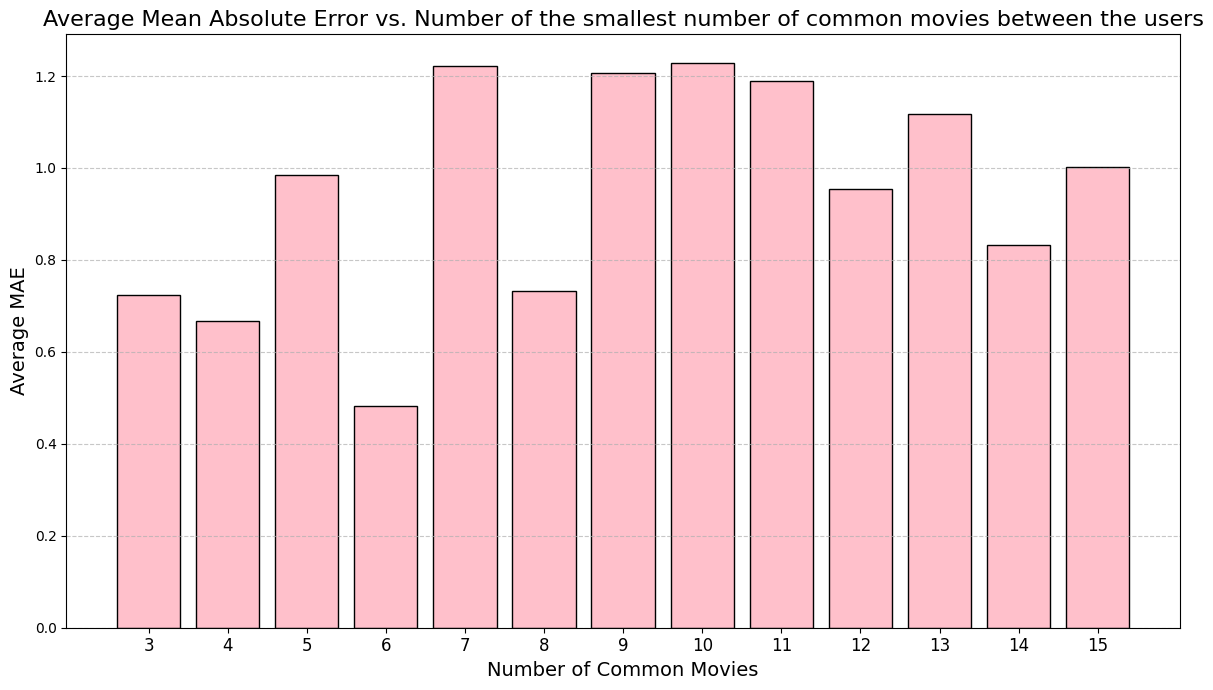

In [52]:
common_movies_values = list(results.keys())
average_maes = [results[cm]["maeAVG"] for cm in common_movies_values]

# Plot the results
plt.figure(figsize=(12, 7))
plt.bar(common_movies_values, average_maes, color='pink', edgecolor='black')
plt.xlabel('Number of Common Movies', fontsize=14)
plt.ylabel('Average MAE', fontsize=14)
plt.title('Average Mean Absolute Error vs. Number of the smallest number of common movies between the users', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(common_movies_values, fontsize=12)
plt.tight_layout()
plt.show()

`The best value for the minimal number of common movies would be 6, since it has the lowest agerage MAE from numbers 3 to 15.` <br>
`Also on this olot we see that the previously selected number of common movies to 5 has quite high average MAE, but here it is quite coincidental that it is this high; when previosly running the code we have achieved that the number 6 was the best with small difference with 7, but 5 was also quite similiar -> so overalll the number of selected common movies is the best between 5 and 7, and for the system we have chosen 6 since it gave as the best results when we run the code for couple of times.`

-----

## 4) Is prediction for a movie seen by just one user trustworthy?
For this to not look at the whole data and look for movies that were rated by only 1 user we use the simplified dataframe (only 10 movies and 15 users) to see what the recommendation for that movie would be

In [39]:
dfTaskSimplified = dfTask.iloc[5:50, :50]


In [40]:
numOfRatings = dfTaskSimplified.notna().sum(axis=1)
movieOnlyBY1User = numOfRatings[numOfRatings == 1]
movieOnlyBY1User

movieId
18    1
27    1
28    1
38    1
dtype: int64

In [41]:
theOnlyUser = dfTaskSimplified.loc[38].dropna().index[0]
theOnlyUserRating = dfTaskSimplified.loc[38, theOnlyUser]
print(f"The movie that was watched by only 1 person was a movie 38, by user {theOnlyUser} and their gave a rating of {theOnlyUserRating}")


The movie that was watched by only 1 person was a movie 38, by user 21 and their gave a rating of 2.5


In [42]:
CalculatetCorrelations(user = 21, commonMovies=2, moviesdf=dfTaskSimplified)

[(6, 1.0),
 (11, 1.0),
 (42, 1.0),
 (19, -0.4942416505721724),
 (40, -0.970725343394151),
 (43, -1.0)]

In [43]:
CalculatetCorrelations(user = 11, commonMovies=2, moviesdf=dfTaskSimplified)

[(21, 1.0), (6, 0.4999999999999999), (19, -1.0), (32, -1.0), (44, -1.0)]

In [44]:
predictScores(user = 11, moviesdf = dfTaskSimplified, commonMovies = 2, topUsers = 5, negativeUsers=0, sortBy='User').tail()

,Movie,Predicted Score,Count of users contributing to prediction,Users on based on which prediction was made details
1,8,3.0,1,"User: 6, Rating: 3.0, Correlation: 0.50"
15,27,3.0,1,"User: 6, Rating: 3.0, Correlation: 0.50"
16,31,3.0,1,"User: 6, Rating: 3.0, Correlation: 0.50"
23,45,3.0,1,"User: 6, Rating: 3.0, Correlation: 0.50"
19,38,2.5,1,"User: 21, Rating: 2.5, Correlation: 1.00"


`Genrally this code for the part is unnecesary since there was a possibility to just look for movies based on the correlation with only 1 user` <br>
`Such a recommendation is not trusthworthy since the system will predict the same rating as the one user who we are basing the prediction on. That is caused by the fact that we use the mean of the top corraleted users to predict the ratig, so if only one person has rated movie the system will assign the same rating to anyone who is positively corralete with them (and inverted rating (5 turns to 1 as suggested on kostultacje) to anyone negatively correlated).`<br>
`So in real world it is best to wait when more users will rate the given movie.`

--------

## *Final Code*

In [56]:
def compareRemovedRatingsGiga(user, numScoresToRemove, moviesdf = dfTaskComparing, topUsers=5, commonMovies = 6, negativeUsers=0):
    moviesdfChanged, removedMovies = removeRatings(user, numScoresToRemove, moviesdf)
    
    predictedRatings = predictScores(user, moviesdfChanged, topUsers=topUsers, commonMovies=commonMovies, negativeUsers=negativeUsers)
    trueRatingsList=[]
    predictedScoresList=[]
    
    for movie in removedMovies:
        trueRating=dfTask.loc[movie, user]
        
        prediction = predictedRatings[predictedRatings['Movie'] == movie]
        if not prediction.empty:
            predictedScore = prediction['Predicted Score'].values[0]
            trueRatingsList.append(trueRating)
            predictedScoresList.append(predictedScore)
        else:
            continue            
    if trueRatingsList and predictedScoresList:
        mae = mean_absolute_error(trueRatingsList, predictedScoresList)
        rmse = np.sqrt(mean_squared_error(trueRatingsList, predictedScoresList))

    else:
        mae = None
        rmse = None
        print(f"Not enough data to calculate evaluation metrics.")
    return predictedRatings, removedMovies, mae, rmse, len(predictedScoresList)

In [60]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
MAEList = []
for user in users:
    sparklingNewdf = dfTask.copy()
    predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
        user=user, moviesdf=sparklingNewdf ,numScoresToRemove=10, topUsers=5, commonMovies=6, negativeUsers=0
    )
    if mae is not None:
        MAEList.append(mae)
        # print(f"User {user} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, Number of Predictions: {numOfPredictions}")
print(f"Average MAE for the users with topUsers=5 and commonMovies=6 : {sum(MAEList) / len(MAEList):.2f}")

Not enough data to calculate evaluation metrics.
Average MAE for the users with topUsers=5 and commonMovies=6 : 0.76


In [61]:
users = [100, 106, 240, 30, 380, 500, 90, 210]
MAEList = []
for user in users:
    sparklingNewdf = dfTask.copy()
    predictedRatings, removedMovies, mae, rmse, numOfPredictions = compareRemovedRatingsGiga(
        user=user, moviesdf=sparklingNewdf ,numScoresToRemove=10, topUsers=30, commonMovies=6, negativeUsers=1
    )
    if mae is not None:
        MAEList.append(mae)
        # print(f"User {user} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, Number of Predictions: {numOfPredictions}")
print(f"Average MAE for the users with topUsers=5 and commonMovies=6 : {sum(MAEList) / len(MAEList):.2f}")

Average MAE for the users with topUsers=5 and commonMovies=6 : 0.87


## *Strengths and weaknesses*

### **Strenghts**
- Adjustability of Parameters: The system allows for parameter tuning, such as the minimal number of common movies and the number of top correlated users, making it really flexible.
- Evaluation Metrics: by using the metrics of MAE (and also RMSE) the system is thouroughly checked for picking the best parameters.

### **Weaknesses**
- No treshold for minimal correlation: we did not set any treshold for the users that we take into the consideration while choosing the number of the users, generally it would be good to set some treshold with absolute value. In place of that we have 'hardcoded' the values of the number of users by testing their preformance with MAE.

----

Try to improve the system, you can use the following ideas:
 - Can we use more users (e.g. with negative correlation)?
 - Which difference is more important predicting 5 when a real score is 4 or predicting 3 instead of 2?
 - Did we use the best value for the minimal number of common movies?
 - Is prediction for a movie seen by just one user trustworthy?
 
 
Describe your approach, its strengths and weaknesses, and analyze the results. Send the report (notebook with comments/markdown) within 144 hours after the class to gmiebs@cs.put.poznan.pl, start the subject with [IR]

Credits to F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872 and Mateusz Lango